# 0. Preparation

In [2]:
import cv2
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
from typing import Optional, Dict, Tuple
import os
import matplotlib.pyplot as plt

# 1. Helper Functions

In [3]:
def show_image(title: str, img: np.ndarray) -> None:
    """
    Display a BGR or grayscale image inside Jupyter Notebook.
    """
    plt.figure(figsize=(6, 4))

    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.title(title)
    plt.axis("off")
    plt.show()

# 2. Main Processing

In [ ]:
# ============================================================
# DETECT REAL IMAGE FORMAT
# ============================================================

def detect_format(path: str) -> Optional[str]:
    """
    Detect image format using PIL.
    Args:
        path: Path to an image file.
    Returns:
        Image format in lowercase ("jpeg", "png", etc) or None if detection fails.
    """
    if not os.path.exists(path):
        print(f"[ERROR] File not found: {path}")
        return None

    try:
        with Image.open(path) as img:
            fmt = img.format
            return fmt.lower() if fmt else None
    except Exception as e:
        print(f"[ERROR] Cannot detect format: {e}")
        return None


# ============================================================
# JPEG ONLY — ERROR LEVEL ANALYSIS (ELA)
# ============================================================
def ela(path: str, quality: int = 90) -> np.ndarray:
    original = Image.open(path).convert("RGB")

    temp_path = "temp_ela.jpg"
    original.save(temp_path, "JPEG", quality=quality)
    compressed = Image.open(temp_path)

    ela_img = ImageChops.difference(original, compressed)

    extrema = ela_img.getextrema()
    max_diff = max([e[1] for e in extrema])
    scale = 255.0 / max_diff if max_diff > 0 else 1
    ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)

    return np.array(ela_img)


# ============================================================
# JPEG ONLY — BLOCK VARIANCE ANALYSIS
# ============================================================
def block_variance(path: str) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")

    h, w = img.shape
    block = 8
    var_map = np.zeros((h // block, w // block))

    for i in range(0, h - block, block):
        for j in range(0, w - block, block):
            patch = img[i:i+block, j:j+block]
            var_map[i // block, j // block] = np.var(patch)

    var_map = cv2.resize(var_map, (w, h), interpolation=cv2.INTER_NEAREST)
    var_map = cv2.normalize(var_map, None, 0, 255, cv2.NORM_MINMAX)
    return var_map.astype(np.uint8)


# ============================================================
# UNIVERSAL — NOISE MAP
# ============================================================

def noise_map(path: str) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")

    blur = cv2.GaussianBlur(img, (5, 5), 0)
    noise = cv2.absdiff(img, blur)
    noise = cv2.normalize(noise, None, 0, 255, cv2.NORM_MINMAX)

    return noise


# ============================================================
# UNIVERSAL — SHARPNESS MAP
# ============================================================
def sharpness_map(path: str) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")

    lap = cv2.Laplacian(img, cv2.CV_64F)
    lap = np.absolute(lap)
    lap = cv2.normalize(lap, None, 0, 255, cv2.NORM_MINMAX)

    return lap.astype(np.uint8)



# ============================================================
# MAIN FORENSIC PIPELINE
# ============================================================
def forensic_pipeline(path: str):
    fmt = detect_format(path)
    if fmt is None:
        raise ValueError("Unknown image format")

    print("[INFO] Running analysis...")

    results: Dict[str, np.ndarray] = {}

    if fmt == "jpeg":
        results["ela"] = ela(path)
        show_image("ELA Map", results["ela"])

        results["block_variance"] = block_variance(path)
        show_image("Block Variance", results["block_variance"])

    results["noise_map"] = noise_map(path)
    show_image("Noise Map", results["noise_map"])

    results["sharpness_map"] = sharpness_map(path)
    show_image("Sharpness Map", results["sharpness_map"])

    heatmap = tampering_heatmap(path, results)
    show_image("Heatmap Overlay", heatmap)

    return results


# ============================================================
# COMPUTE FORENSIC SCORES
# ============================================================
def compute_scores(results: Dict[str, np.ndarray]) -> Dict[str, float]:
    scores: Dict[str, float] = {}

    # ELA score
    if "ela" in results:
        ela_gray = cv2.cvtColor(results["ela"], cv2.COLOR_RGB2GRAY)
        scores["ela_mean"] = float(np.mean(ela_gray))
    else:
        scores["ela_mean"] = 0.0

    # Noise & sharpness are already grayscale
    noise = results["noise_map"]
    sharp = results["sharpness_map"]

    scores["noise_std"] = float(np.std(noise))
    scores["sharpness_mean"] = float(np.mean(sharp))

    return scores


# ============================================================
# DECISION ENGINE
# ============================================================

def decide_fakeness(scores: Dict[str, float], fmt: Optional[str]) -> Tuple[str, int]:
    """
    Decide whether image is likely fake.
    Returns: ("FAKE"/"REAL", fraud_score)
    """
    ELA_THRESHOLD = 40
    NOISE_THRESHOLD = 25
    SHARPNESS_THRESHOLD = 60

    ela_flag = scores["ela_mean"] > ELA_THRESHOLD if fmt == "jpeg" else False
    noise_flag = scores["noise_std"] > NOISE_THRESHOLD
    sharp_flag = scores["sharpness_mean"] > SHARPNESS_THRESHOLD

    fraud_score = int(ela_flag + noise_flag + sharp_flag)
    result = "FAKE" if fraud_score >= 2 else "REAL"
    return result, fraud_score


# ============================================================
# TAMPERING HEATMAP
# ============================================================
def tampering_heatmap(path: str, results: Dict[str, np.ndarray]) -> np.ndarray:
    orig = cv2.imread(path)
    if orig is None:
        raise FileNotFoundError(f"Unable to read original image: {path}")

    noise = results["noise_map"]
    sharp = results["sharpness_map"]

    noise_norm = noise.astype(np.float32) / 255.0
    sharp_norm = sharp.astype(np.float32) / 255.0

    anomaly = (noise_norm * 0.5) + (sharp_norm * 0.5)

    if "ela" in results:
        ela_gray = cv2.cvtColor(results["ela"], cv2.COLOR_RGB2GRAY)
        anomaly += (ela_gray.astype(np.float32) / 255.0) * 0.7

    if "block_variance" in results:
        bv = results["block_variance"]
        anomaly += (bv.astype(np.float32) / 255.0) * 0.4

    anomaly /= anomaly.max() if anomaly.max() > 0 else 1
    anomaly = cv2.GaussianBlur(anomaly, (21, 21), 0)

    heatmap = (anomaly * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_color = cv2.resize(heatmap_color, (orig.shape[1], orig.shape[0]))

    overlay = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)
    return overlay

[INFO] Running analysis...


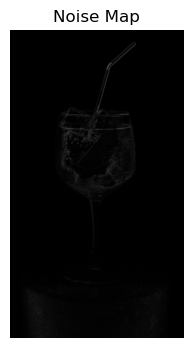

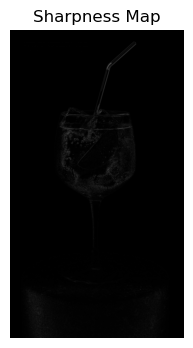

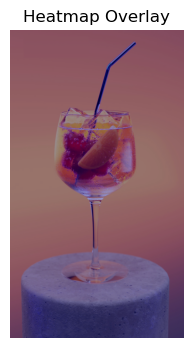


[INFO] Forensic scores: {'ela_mean': 0.0, 'noise_std': 6.888652057152319, 'sharpness_mean': 2.043879458161866}

[RESULT] Decision: REAL (fraud score = 0)


In [10]:
image_path = "../../input/glass-fake-3.jpg"
results = forensic_pipeline(image_path)
fmt = detect_format(image_path)

scores = compute_scores(results)
print("\n[INFO] Forensic scores:", scores)

decision, fraud_score = decide_fakeness(scores, fmt)
print(f"\n[RESULT] Decision: {decision} (fraud score = {fraud_score})")